In [1]:
import sys
sys.path.append('../../neurodynlib/')
import neurodynlib as nd
from brian2.units import *
import brian2 as b2
import matplotlib.pyplot as plt
from brian2tools import plot_synapses, add_background_pattern, brian_plot
import numpy as np

#b2.codegen.target = 'numpy'

## Create the network neurons

In [2]:
x = nd.LifNeuron()

In [3]:
# Parameters from Song&Abbott 2001
capacitance = 50*pF
g_leak = 2.5*nS
x.set_neuron_parameters(C=capacitance, gL=g_leak, EL=-74*mV, VT=-54*mV, V_res=-60*mV)  
x.set_excitatory_receptors('SIMPLE_E')
x.set_inhibitory_receptors('SIMPLE_I')
x.set_neuron_parameters(tau_e=5*ms, tau_i=5*ms, Ee=0*mV, Ei=-70*mV)  # Not sure what tau_i should be

In [4]:
x.get_neuron_parameters()

{'EL': -74. * mvolt,
 'V_res': -60. * mvolt,
 'VT': -54. * mvolt,
 'gL': 2.5 * nsiemens,
 'C': 50. * pfarad,
 'refractory_period': 2. * msecond,
 'tau_e': 5. * msecond,
 'tau_i': 5. * msecond,
 'Ee': 0. * volt,
 'Ei': -70. * mvolt}

In [5]:
# Create a network of 200 LIF neurons
network_group = x.make_neuron_group(200)
network_group

NeuronGroup(clock=Clock(dt=100. * usecond, name='defaultclock'), when=start, order=0, name='neurongroup')

In [6]:
# Add background input
# Poisson input at 500 Hz, weight 0.096; except Fig 5 higher weight
bg_weight = 0.096 * g_leak
background_input = b2.PoissonInput(network_group, 'ge', 1, 500*Hz, weight=bg_weight)

## Create input neurons

In [7]:
# Stimulus space = scalars from 0 to 1000
N_inputs = 1000
a_inputs = np.arange(0, 1000, 1.0)

In [8]:
def inputneuron(a, s):
    R_0 = 10.0*Hz
    R_1 = 80.0*Hz
    sigma = 100.0
    
    rate = R_0 + R_1 * (np.exp(-(s-a)**2/(2*sigma**2)) + np.exp(-(s+1000-a)**2/(2*sigma**2)) + np.exp(-(s-1000-a)**2/(2*sigma**2)))
    
    return rate

WARNING    /home/henhok/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  
 [py.warnings]
  



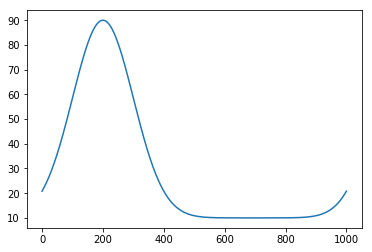

In [9]:
a = 200
s_values = np.linspace(0,1000.0,1e4)
r_values = [inputneuron(a, s) for s in s_values]
plt.plot(s_values, r_values)

In [30]:
create_presentations = 0
pres_savefile = 'tmp_pres_save.npy'
pres_loadfile = 'presentations_200s_ver3.npy'

if create_presentations == 1:
    # Create brief presentations of stimulus at random locations
    # Length of each presentation chosen from exponential distribution with mean of 20 ms
    N_presentations = 10000
    presentation_mean_duration = 20  # in milliseconds

    # Get random presentation lengths
    presentation_durations = np.random.exponential(scale=presentation_mean_duration, size=N_presentations).astype(int)
    total_presentation_duration = np.sum(presentation_durations)  # in milliseconds

    # Create a matrix of size N_inputs x total_duration_dt_1ms (+1, see just after for loop)
    presentation_matrix = np.zeros((N_inputs, total_presentation_duration+1))
    next_pres_start = 0

    # Pick a random stimulus, then get rate of each of the 1000 input neurons
    for pres_ix in range(N_presentations): 
        stimulus = np.random.uniform(0, 1000)
        stim_rates = np.array([[inputneuron(a, stimulus)] for a in a_inputs])
        # Add the rates to presentation duration-many columns
        dur = presentation_durations[pres_ix]
        presentation = np.tile(stim_rates, (1, dur))
        presentation_matrix[:, next_pres_start:next_pres_start+dur] = presentation
        next_pres_start = next_pres_start+dur
    
    # We set last rate uniformly at 10; otherwise Brian will keep on showing the last presentation ad infinitum
    presentation_matrix[:, total_presentation_duration] = 10 * np.ones(N_inputs)
    
    np.save(pres_savefile, presentation_matrix)
 
else: 
    presentation_matrix = np.load(pres_loadfile)

(1000, 191609)


Text(0.5, 0, 'Time [ms]')

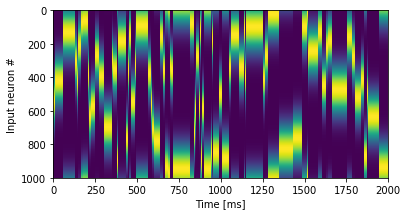

In [11]:
# Visualize the rate matrix (first 2000ms)
print(np.shape(presentation_matrix))
plt.imshow(presentation_matrix[:,:2000])
plt.ylabel('Input neuron #')
plt.xlabel('Time [ms]')

In [12]:
# Create PoissonGroup with the rates defined above 
# Brian2 TimedArray: time as the first and neuron index as the second dimension
presentations_array = b2.TimedArray(presentation_matrix.T * Hz, dt=1*ms)
input_group = b2.PoissonGroup(N_inputs, rates='presentations_array(t, i)')

## Connect everything

In [13]:
# Plasticity parameters
A_plus = 0.01  # A_plus = 0.001
tau_plus = 20*ms
tau_minus = 20*ms  # Song&Abbott use alternatively 100*ms here (as long as tau_minus >= tau_plus)

# B = A_minus*tau_minus / (A_plus*tau_plus) aka the "STDP window function"
B_ff = 1.06
B_recur = 1.04

A_minus_ff = -B_ff * A_plus * tau_plus / tau_minus
A_minus_recur = -B_recur * A_plus * tau_plus / tau_minus

g_max = 0.02 * g_leak
g_inhib = 0.3 * g_max

dAplus = A_plus * g_max  # pre increment
dAminus_ff = A_minus_ff * g_max  # post increment for feedforward synapses
dAminus_recur = A_minus_recur * g_max  # post increment for recurrent synapses 

In [14]:
# Input->network (20% probability; excitatory)

syn_input = b2.Synapses(input_group, network_group, '''
               w: siemens
               dApre/dt = -Apre/tau_plus : siemens (event-driven)
               dApost/dt = -Apost/tau_minus : siemens (event-driven)''', 
               on_pre = '''ge_post += w
                           Apre += dAplus
                           w = clip(w + Apost, 0*nS, g_max)''', 
              on_post='''
              Apost += dAminus_ff
              w = clip(w + Apre, 0*nS, g_max)''')

syn_input.connect(p=0.2)

In [15]:
connectivity_type = 2

# Option 1: All-to-all excitatory connections in the network
if connectivity_type == 1:
    syn_network_exc = b2.Synapses(network_group, network_group, '''
               w: siemens
               dApre/dt = -Apre/tau_plus : siemens (event-driven)
               dApost/dt = -Apost/tau_minus : siemens (event-driven)''', 
               on_pre = '''ge_post += w
                           Apre += dAplus
                           w = clip(w + Apost, 0*nS, g_max)''', 
              on_post='''
              Apost += dAminus_recur
              w = clip(w + Apre, 0*nS, g_max)''')
    
    syn_network_exc.connect(condition='i != j')

# Option 2: Local excitatory connections and all-to-all uniform inhibitory connections
elif connectivity_type == 2:
    syn_network_exc = b2.Synapses(network_group, network_group, '''
               w: siemens
               dApre/dt = -Apre/tau_plus : siemens (event-driven)
               dApost/dt = -Apost/tau_minus : siemens (event-driven)''', 
               on_pre = '''ge_post += w
                           Apre += dAplus
                           w = clip(w + Apost, 0*nS, g_max)''', 
              on_post='''
              Apost += dAminus_recur
              w = clip(w + Apre, 0*nS, g_max)''')
    
    syn_network_exc.connect(condition='abs(i-j) <= 40 and i != j')
    syn_network_exc.connect(condition='200-abs(i-j) <= 40 and i != j')  # Wrap the network in a circle
    
    syn_network_inh = b2.Synapses(network_group, network_group,
                                 on_pre='gi_post += g_inhib')
    syn_network_inh.connect(condition='i != j')

## Initialize weights

In [16]:
# Initialize weights etc
syn_input.w = 'rand()*0.5*g_max'
syn_network_exc.w = 0*siemens

syn_input.delay = 2*ms
syn_network_exc.delay = 2*ms
syn_network_inh.delay = 2*ms

## Run!

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.02s, trying other methods took 0.04s). [brian2.stateupdaters.base.method_choice]


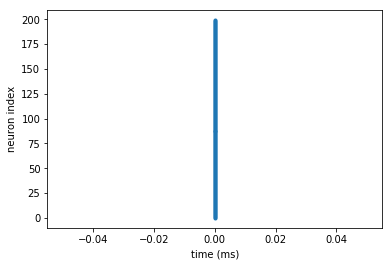

In [17]:
sp_network = b2.SpikeMonitor(network_group)
sp_input = b2.SpikeMonitor(input_group)

b2.run(1*ms)
from brian2tools import brian_plot
brian_plot(sp_network)

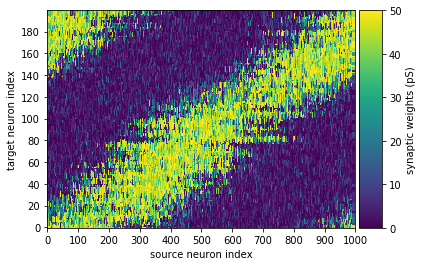

In [23]:
# Requires ~200 seconds to converge
b2.run(0*second)
ax = plot_synapses(syn_input.i, syn_input.j, syn_input.w, var_name='synaptic weights',
                   plot_type='scatter', cmap='viridis')

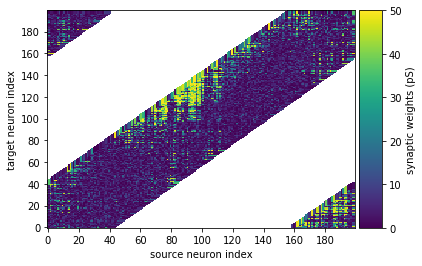

In [24]:
ax = plot_synapses(syn_network_exc.i, syn_network_exc.j, syn_network_exc.w, var_name='synaptic weights',
                   plot_type='scatter', cmap='viridis')